# Fred Data
This notebooks pull down and saves macro data from the FRED service. The associated files are small and will be written to the directory when done, so it's not necessary to run locally unless you want to update the data.

FredUtils.py provides a wrapper for querying FRED using the fredapi python package, while throttling the request rate to be a "good citizen" (and avoid getting flagged as a bad actor and blocked). Querying FRED requires an API key which is referenced here as FRED_API_Key.txt in the same folder. You can [request an API key](https://research.stlouisfed.org/docs/api/api_key.html) from FRED for free with registration. Once you have a key, copy and paste it into a text file and change the input to intialize_fred below accordingly. You should also add your API to the .gitignore to avoid it getting posted here and being publicly visible.

In [107]:
# Imports
import FredUtils, pandas as pd, matplotlib.pyplot  as plt

# Get and save macro data (skip this section if you want to load from a file)

In [33]:
# Initialize the FRED API key connection
fred = FredUtils.initialize_fred("FRED_API_Key.txt")

In [67]:
# Set the desired series to query and their associated names
seriesToQuery = {'MORTGAGE30US': '30-Year Mortgage Rate' ,'DGS10':'10-Year Treasury Rate', 'WPUSI012011':'PPI Construction',
                 'SP500': 'S&P500', 'UNRATE': 'Unemployment Rate','PSAVERT':'Savings Rate', 'WILL5000IND':'Wilshire 5000', 
                 'GDP' : 'GDP', 'SPCS20RSA':'Case-Shiller Index'}
seriesResults = dict()

In [68]:
# Download the data from FRED
for series, name in seriesToQuery.items():
    reqResult = FredUtils.req_series(fred, series).to_frame().set_axis([name],axis=1,inplace=False)
    seriesResults[name] = reqResult

Sleeping for 0:00:00.120234
Sleeping for 0:00:00.090253
Sleeping for 0:00:00.163209
Sleeping for 0:00:00.233166


In [97]:
# Join data, fill forward, then downsample to monthly frequency by taking the latest observation at each point
macroData = pd.concat([d for d in seriesResults.values()], axis=1).ffill().resample('M').last()
macroData.index.rename('Month',inplace=True)
macroData = macroData.loc['2000-01-01':]

In [99]:
# Save the data to a file
macroData.to_csv('macroData.csv')

# Data exploration and visualization

In [150]:
macroData = pd.read_csv('macroData.csv').set_index('Month')
macroData.tail()

,30-Year Mortgage Rate,10-Year Treasury Rate,PPI Construction,S&P500,Unemployment Rate,Savings Rate,Wilshire 5000,GDP,Case-Shiller Index
Month,,,,,,,,,
2021-02-28,2.97,1.44,263.6,3811.15,6.2,14.7,190.48,22061.025,248.181933
2021-03-31,3.17,1.74,275.6,3972.89,6.0,27.7,197.48,22061.025,252.142129
2021-04-30,2.98,1.65,290.0,4181.17,6.1,14.9,207.91,22061.025,252.142129
2021-05-31,2.95,1.58,303.3,4204.11,5.8,14.9,208.87,22061.025,252.142129
2021-06-30,2.93,1.57,303.3,4166.45,5.8,14.9,210.33,22061.025,252.142129


macroData

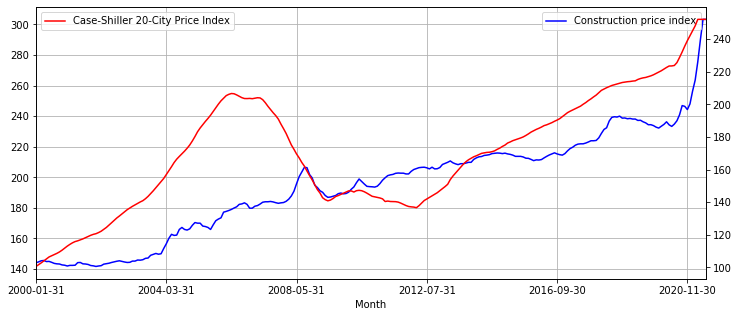

In [151]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = macroData['PPI Construction'].plot(color='blue', grid=True, label='Construction price index')
ax2 = macroData['Case-Shiller Index'].plot(color='red', grid=True, secondary_y=True, label='Case-Shiller 20-City Price Index')

ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

In [152]:
corr = macroData.diff(4).corr()
corr.style.background_gradient(cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2).set_caption('Correlation of quarterly changes for macro variables')

,30-Year Mortgage Rate,10-Year Treasury Rate,PPI Construction,S&P500,Unemployment Rate,Savings Rate,Wilshire 5000,GDP,Case-Shiller Index
30-Year Mortgage Rate,1,0.81,0.32,0.051,-0.13,-0.02,0.23,0.16,0.2
10-Year Treasury Rate,0.81,1,0.31,0.41,-0.22,-0.11,0.45,0.29,0.25
PPI Construction,0.32,0.31,1,0.44,-0.19,-0.019,0.41,0.22,0.24
S&P500,0.051,0.41,0.44,1,-0.29,-0.33,0.99,0.35,0.37
Unemployment Rate,-0.13,-0.22,-0.19,-0.29,1,0.78,-0.31,-0.89,-0.24
Savings Rate,-0.02,-0.11,-0.019,-0.33,0.78,1,-0.24,-0.69,-0.056
Wilshire 5000,0.23,0.45,0.41,0.99,-0.31,-0.24,1,0.38,0.35
GDP,0.16,0.29,0.22,0.35,-0.89,-0.69,0.38,1,0.26
Case-Shiller Index,0.2,0.25,0.24,0.37,-0.24,-0.056,0.35,0.26,1


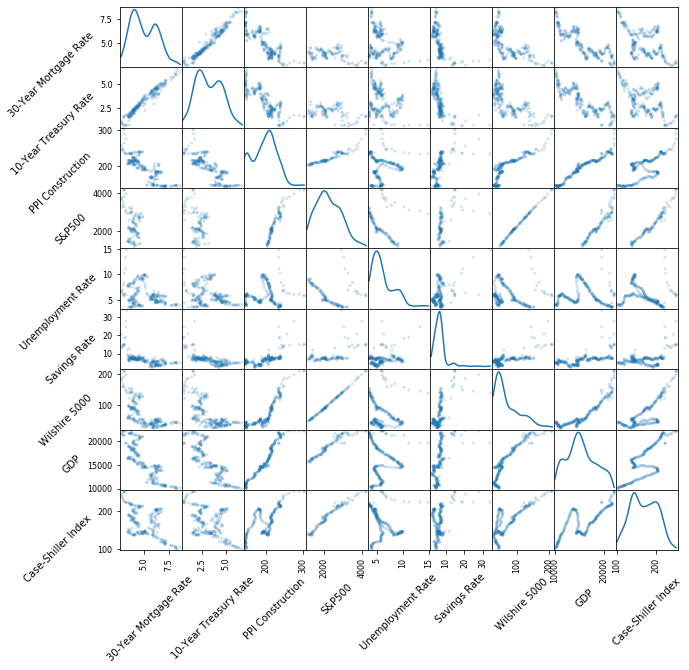

In [164]:
axes = pd.plotting.scatter_matrix(macroData, alpha=0.2, figsize=(10,10), diagonal='kde')
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')
plt.show()